In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

#1. EDA

In [ ]:
# Membaca dataset
df = pd.read_csv('/content/ObesityDataSet.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             2097 non-null   object
 1   Gender                          2102 non-null   object
 2   Height                          2099 non-null   object
 3   Weight                          2100 non-null   object
 4   CALC                            2106 non-null   object
 5   FAVC                            2100 non-null   object
 6   FCVC                            2103 non-null   object
 7   NCP                             2099 non-null   object
 8   SCC                             2101 non-null   object
 9   SMOKE                           2106 non-null   object
 10  CH2O                            2105 non-null   object
 11  family_history_with_overweight  2098 non-null   object
 12  FAF                             2103 non-null   

In [ ]:
print("Beberapa baris pertama:")
print(df.head())

Beberapa baris pertama:
  Age  Gender Height Weight        CALC FAVC FCVC NCP  SCC SMOKE CH2O  \
0  21  Female   1.62     64          no   no    2   3   no    no    2   
1  21  Female   1.52     56   Sometimes   no    3   3  yes   yes    3   
2  23    Male    1.8     77  Frequently   no    2   3   no    no    2   
3  27    Male    1.8     87  Frequently   no    3   3   no    no    2   
4  22    Male   1.78   89.8   Sometimes   no    2   1   no    no    2   

  family_history_with_overweight FAF TUE       CAEC                 MTRANS  \
0                            yes   0   1  Sometimes  Public_Transportation   
1                            yes   3   0  Sometimes  Public_Transportation   
2                            yes   2   1  Sometimes  Public_Transportation   
3                             no   2   0  Sometimes                Walking   
4                             no   0   0  Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_We

In [ ]:
print("\nDeskripsi Statistik:")
print(df.describe())


Deskripsi Statistik:
         Age Gender Height Weight       CALC  FAVC  FCVC   NCP   SCC SMOKE  \
count   2097   2102   2099   2100       2106  2100  2103  2099  2101  2106   
unique  1394      3   1562   1518          5     3   808   637     3     3   
top       18   Male    1.7     80  Sometimes   yes     3     3    no    no   
freq     124   1056     58     58       1386  1844   647  1183  1997  2054   

        CH2O family_history_with_overweight   FAF   TUE       CAEC  \
count   2105                           2098  2103  2102       2100   
unique  1263                              3  1186  1130          5   
top        2                            yes     0     0  Sometimes   
freq     441                           1705   404   552       1747   

                       MTRANS      NObeyesdad  
count                    2105            2111  
unique                      6               7  
top     Public_Transportation  Obesity_Type_I  
freq                     1572             35

In [ ]:
#Cek missing Value
df.isnull().sum()

,0
Age,14
Gender,9
Height,12
Weight,11
CALC,5
FAVC,11
FCVC,8
NCP,12
SCC,10
SMOKE,5


In [ ]:
#Cek unique values
df.nunique()

,0
Age,1394
Gender,3
Height,1562
Weight,1518
CALC,5
FAVC,3
FCVC,808
NCP,637
SCC,3
SMOKE,3


In [ ]:
#Cek duplikasi
df.duplicated().sum()

18

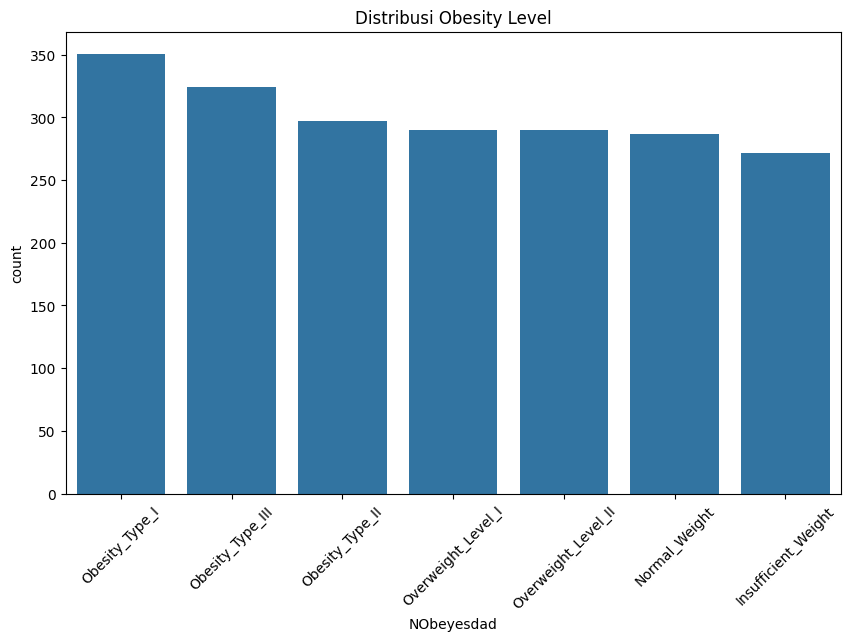

In [ ]:
# Distribusi target dan visualisasi
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="NObeyesdad", order=df["NObeyesdad"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Obesity Level")
plt.show()

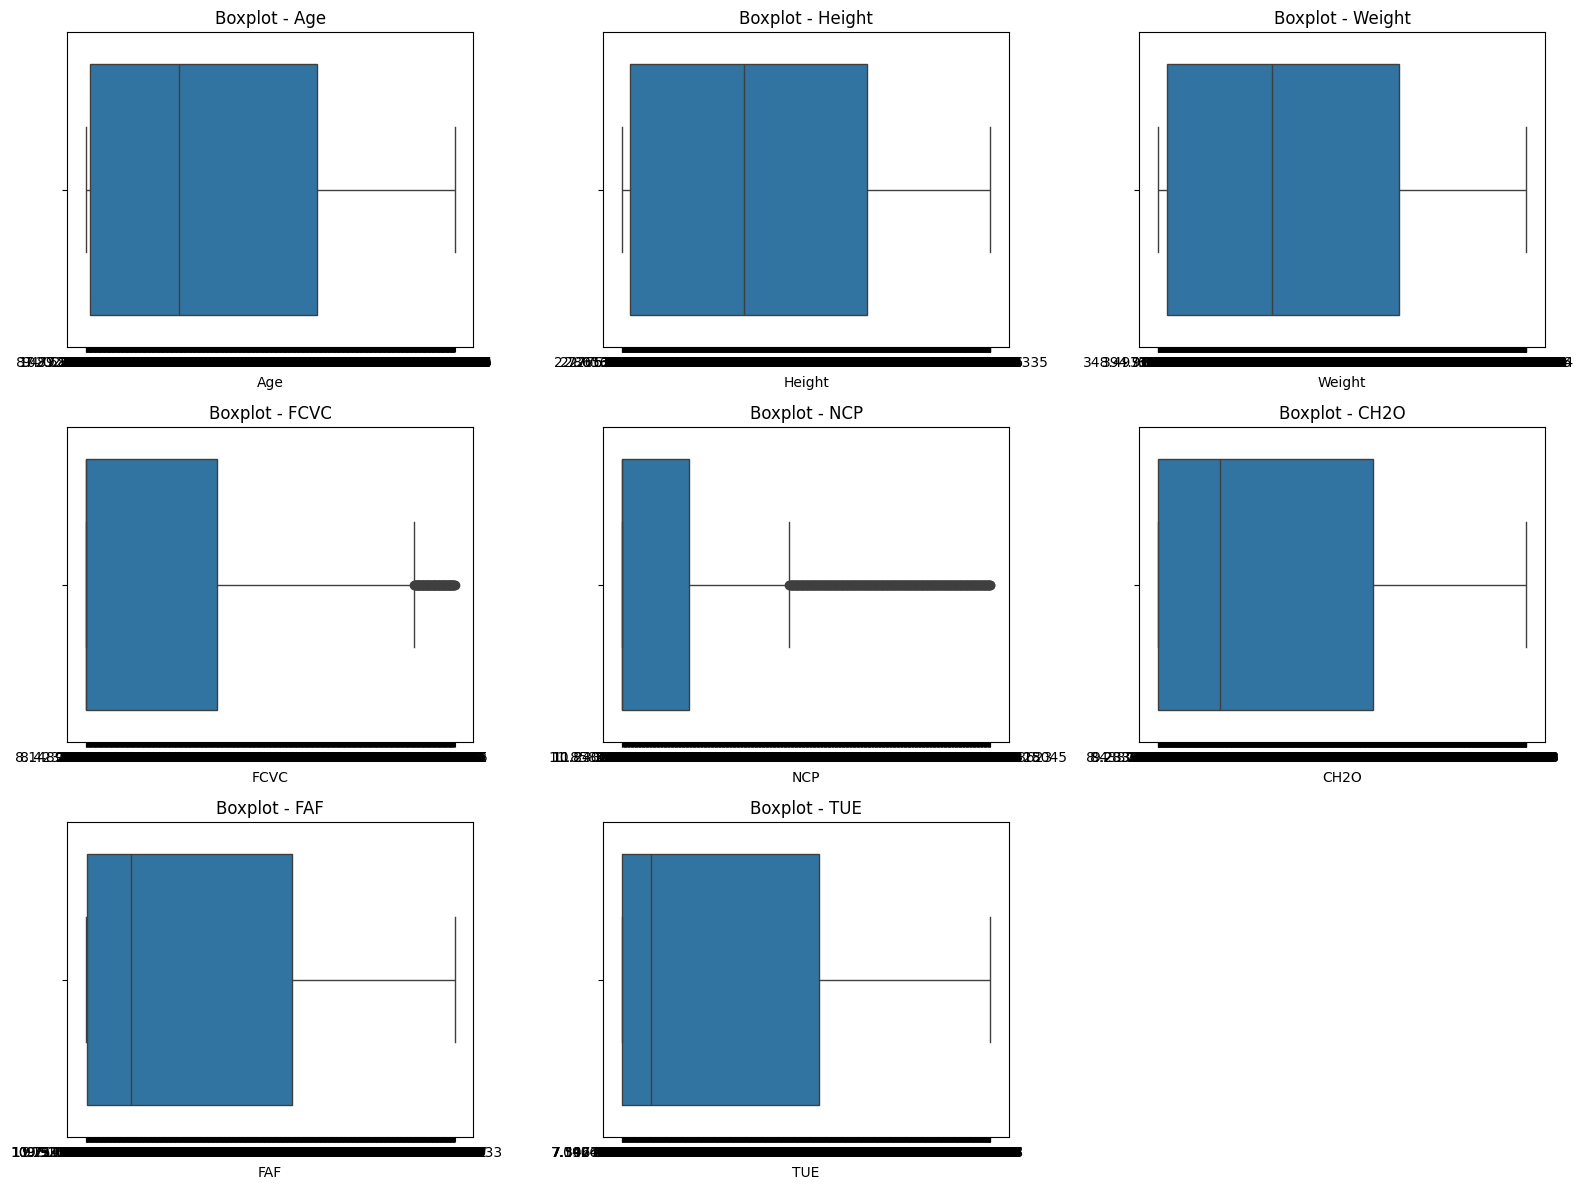

In [ ]:
# Boxplot untuk deteksi outlier numerik
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()


#2. Preprocessing Data

In [ ]:
# Menangani duplikat
print("Jumlah baris sebelum menghapus duplikat:", df.shape[0])
df = df.drop_duplicates()
print("Jumlah baris setelah menghapus duplikat:", df.shape[0])

Jumlah baris sebelum menghapus duplikat: 2111
Jumlah baris setelah menghapus duplikat: 2093


In [ ]:
# Sebelum hapus outlier Weight:
print("Jumlah baris sebelum menghapus outlier Weight:", df.shape[0])

# Periksa nilai non-numerik di kolom 'Weight' dan konversi ke numerik
# Parameter 'errors='coerce'' akan mengubah nilai non-numerik menjadi NaN
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

# Hapus baris dengan nilai NaN di kolom 'Weight' yang mungkin muncul setelah konversi
df.dropna(subset=['Weight'], inplace=True)

# Hitung Q1 dan Q3 setelah memastikan kolom 'Weight' hanya berisi angka
Q1 = df['Weight'].quantile(0.25)
Q3 = df['Weight'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Weight'] >= Q1 - 1.5 * IQR) & (df['Weight'] <= Q3 + 1.5 * IQR)]
print("Jumlah baris setelah menghapus outlier Weight:", df.shape[0])

Jumlah baris sebelum menghapus outlier Weight: 2093
Jumlah baris setelah menghapus outlier Weight: 2059


<ipython-input-77-f89c201e912a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')
<ipython-input-77-f89c201e912a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Weight'], inplace=True)


In [ ]:
le = LabelEncoder()
df['NObeyesdad'] = le.fit_transform(df['NObeyesdad'])
print("Label target setelah encoding:", df['NObeyesdad'].unique())

Label target setelah encoding: [1 5 6 2 0 3 4]


In [ ]:
# Definisikan fitur numerik dan kategorikal
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'Age', 'Height', 'Weight', 'CALC', 'FAVC', 'SCC', 'MTRANS'] # Sesuaikan dengan kolom kategorikal di dataset Anda

numerical = numerical_features
categorical = categorical_features

print("Fitur numerik:", numerical)
print("Fitur kategorikal:", categorical)

Fitur numerik: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Fitur kategorikal: ['Gender', 'Age', 'Height', 'Weight', 'CALC', 'FAVC', 'SCC', 'MTRANS']


In [ ]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_features = ['Gender', 'CALC', 'FAVC', 'SCC', 'MTRANS']

print("Checking numerical features for non-numeric values and handling them...")
for col in numerical_features:
    if col in X_train.columns:


        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

        initial_rows_train = X_train.shape[0]
        initial_rows_test = X_test.shape[0]
        X_train.dropna(subset=[col], inplace=True)
        X_test.dropna(subset=[col], inplace=True)

        y_train = y_train.loc[X_train.index]
        y_test = y_test.loc[X_test.index]
        if X_train.shape[0] < initial_rows_train:
            print(f"Dropped {initial_rows_train - X_train.shape[0]} rows with non-numeric or missing values in '{col}' from training data.")
        if X_test.shape[0] < initial_rows_test:
             print(f"Dropped {initial_rows_test - X_test.shape[0]} rows with non-numeric or missing values in '{col}' from testing data.")
    else:
        print(f"Warning: Numerical feature '{col}' not found in the dataframe columns.")
print("Cleaning of numerical features complete.")



numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],

    remainder='drop' #Buang kolom sisa
)


X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


print("Shape data train setelah scaling:", X_train_scaled.shape)
print("Shape data test setelah scaling:", X_test_scaled.shape)

Checking numerical features for non-numeric values and handling them...
Dropped 17 rows with non-numeric or missing values in 'Age' from training data.
Dropped 5 rows with non-numeric or missing values in 'Age' from testing data.
Dropped 19 rows with non-numeric or missing values in 'Height' from training data.
Dropped 3 rows with non-numeric or missing values in 'Height' from testing data.
Dropped 14 rows with non-numeric or missing values in 'FCVC' from training data.
Dropped 4 rows with non-numeric or missing values in 'FCVC' from testing data.
Dropped 15 rows with non-numeric or missing values in 'NCP' from training data.
Dropped 7 rows with non-numeric or missing values in 'NCP' from testing data.
Dropped 12 rows with non-numeric or missing values in 'CH2O' from training data.
Dropped 3 rows with non-numeric or missing values in 'CH2O' from testing data.
Dropped 15 rows with non-numeric or missing values in 'FAF' from training data.
Dropped 4 rows with non-numeric or missing value

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("Sebelum SMOTE:", np.bincount(y_train))
print("Setelah SMOTE:", np.bincount(y_train_res))

Sebelum SMOTE: [198 209 263 224 234 206 208]
Setelah SMOTE: [263 263 263 263 263 263 263]


#3.    Pemodelan dan Evaluasi

In [ ]:
# Inisialisasi model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True)
}

In [ ]:
# Menyimpan hasil evaluasi
results = []

In [ ]:
# Nama kelas asli (sebagai string) untuk laporan
class_names_list = le.classes_.tolist()


 Model: Logistic Regression
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      1.00      0.89        50
      Normal_Weight       0.76      0.64      0.69        55
     Obesity_Type_I       0.98      0.91      0.95        67
    Obesity_Type_II       0.93      1.00      0.96        54
   Obesity_Type_III       1.00      0.98      0.99        55
 Overweight_Level_I       0.63      0.65      0.64        51
Overweight_Level_II       0.78      0.75      0.76        52

           accuracy                           0.85       384
          macro avg       0.84      0.85      0.84       384
       weighted avg       0.85      0.85      0.85       384



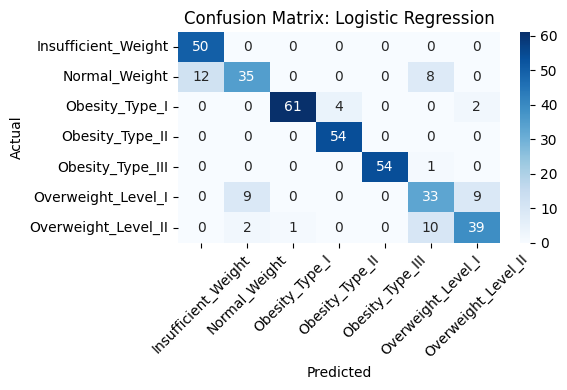


 Model: Random Forest
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.98      0.95        50
      Normal_Weight       0.84      0.89      0.87        55
     Obesity_Type_I       1.00      0.99      0.99        67
    Obesity_Type_II       1.00      1.00      1.00        54
   Obesity_Type_III       1.00      1.00      1.00        55
 Overweight_Level_I       0.93      0.82      0.88        51
Overweight_Level_II       0.91      0.92      0.91        52

           accuracy                           0.95       384
          macro avg       0.94      0.94      0.94       384
       weighted avg       0.95      0.95      0.95       384



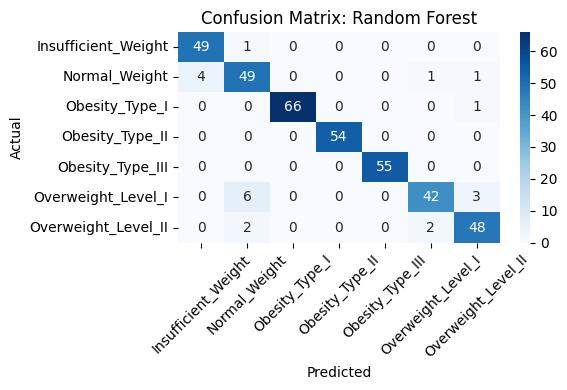


 Model: SVM
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.94      0.90        50
      Normal_Weight       0.75      0.76      0.76        55
     Obesity_Type_I       0.97      0.96      0.96        67
    Obesity_Type_II       0.93      0.98      0.95        54
   Obesity_Type_III       1.00      0.95      0.97        55
 Overweight_Level_I       0.77      0.80      0.79        51
Overweight_Level_II       0.96      0.83      0.89        52

           accuracy                           0.89       384
          macro avg       0.89      0.89      0.89       384
       weighted avg       0.89      0.89      0.89       384



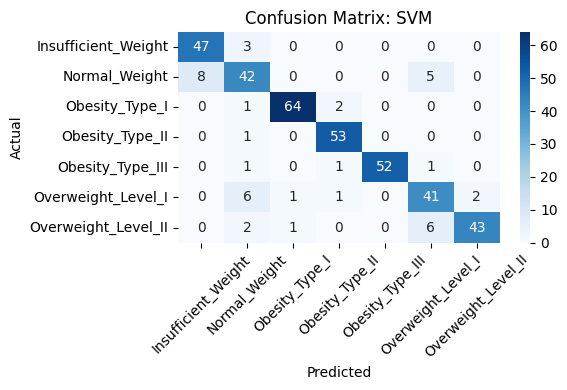

In [ ]:
# Loop semua model
for name, model in models.items():
    print(f"\n Model: {name}")

    # Latih model
    model.fit(X_train_res, y_train_res)

    # Prediksi
    y_pred = model.predict(X_test_scaled)

    # Evaluasi metrik
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cetak classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names_list))

    # Simpan hasil
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    # Tampilkan confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names_list, yticklabels=class_names_list)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Konversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Tampilkan tabel hasil
print("\n📊 Perbandingan Hasil Model:")
print(results_df)


📊 Perbandingan Hasil Model:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.848958   0.849716  0.848958  0.846711
1        Random Forest  0.945312   0.946318  0.945312  0.945146
2                  SVM  0.890625   0.894008  0.890625  0.891159


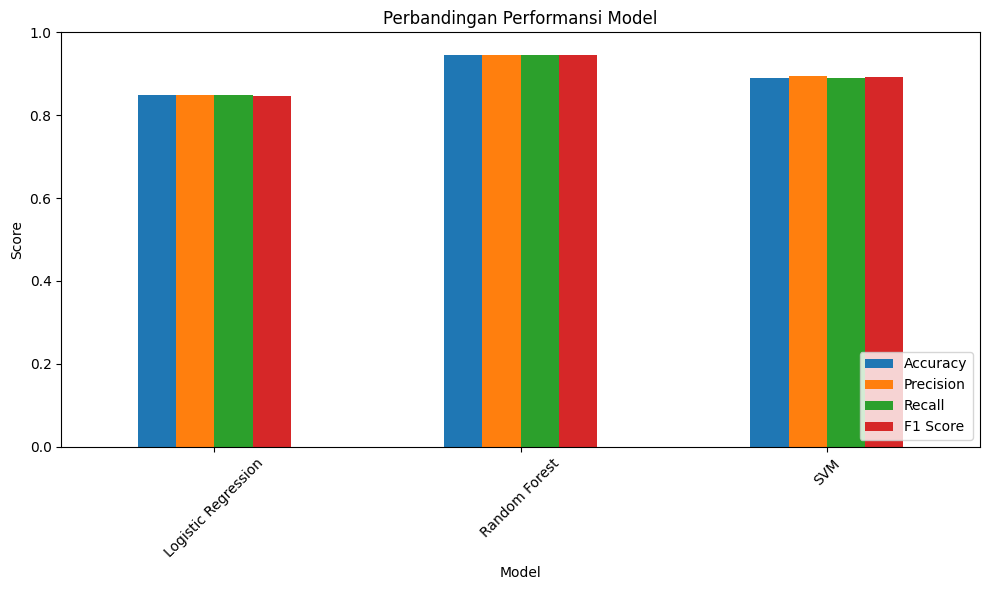

In [ ]:
# Visualisasi perbandingan performa model
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(10, 6))
plt.title("Perbandingan Performansi Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


#4. Hyperparameter Tuning

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Parameter terbaik ditemukan: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Performa Random Forest Setelah Tuning:
Akurasi     0.937500
Presisi     0.938424
Recall      0.937500
F1-Score    0.937367
dtype: float64


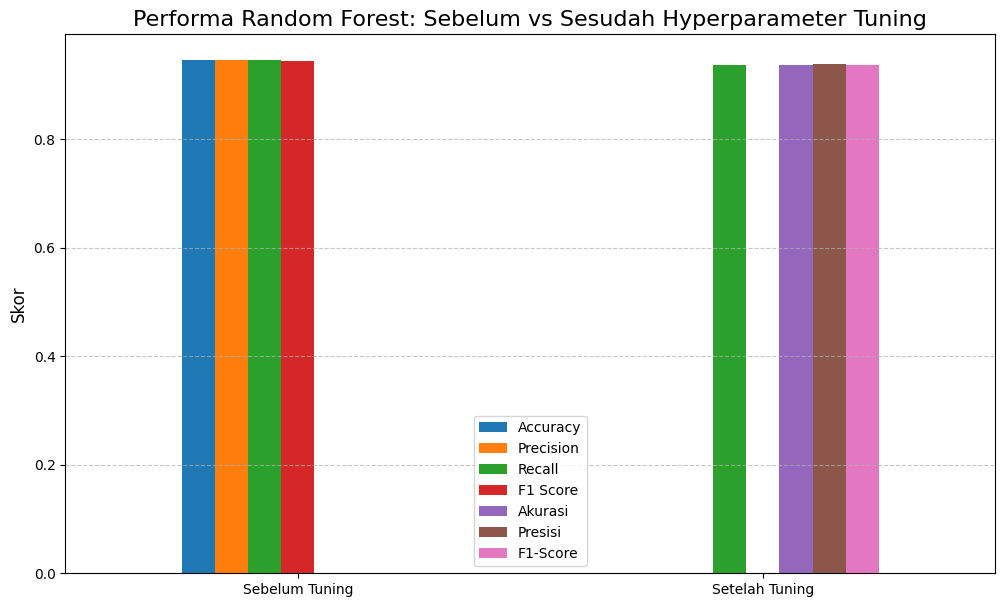

In [ ]:
# Tentukan parameter grid untuk Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inisialisasi GridSearchCV
# Use the best performing model (RandomForestClassifier)
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           n_jobs=-1, # Gunakan semua core CPU
                           verbose=1,
                           scoring='f1_weighted')

# Lakukan pencarian pada data training yang sudah di-preprocess dan di-resample
grid_search.fit(X_train_res, y_train_res)

# Tampilkan parameter terbaik
print(f"Parameter terbaik ditemukan: {grid_search.best_params_}")

# Latih ulang model dengan parameter terbaik dan evaluasi
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled) # Prediksi menggunakan data test yang sudah di-preprocess

# Evaluasi model yang telah dioptimalkan
tuned_results = {
    "Akurasi": accuracy_score(y_test, y_pred_best),
    "Presisi": precision_score(y_test, y_pred_best, average='weighted'),
    "Recall": recall_score(y_test, y_pred_best, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_best, average='weighted')
}

print("\nPerforma Random Forest Setelah Tuning:")
print(pd.Series(tuned_results))

# Convert results list to a dictionary for easier access
results_dict = {item['Model']: {key: value for key, value in item.items() if key != 'Model'} for item in results}

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Sebelum Tuning': results_dict['Random Forest'],
    'Setelah Tuning': tuned_results
})

# Visualisasi perbandingan
comparison_df.T.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Performa Random Forest: Sebelum vs Sesudah Hyperparameter Tuning', fontsize=16)
plt.ylabel('Skor', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()